# Content Based Recommendation - Part 2

> [Yalim Demirkesen](github.com/demirkeseny)



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from ast import literal_eval
import progressbar
from time import sleep
import numpy as np

In [2]:
# now we might require more documents since the metadata includes more interaction
credits = pd.read_csv('C:/Users/demir/Desktop/movie-recommender/data/credits.csv')
keywords = pd.read_csv('C:/Users/demir/Desktop/movie-recommender/data/keywords.csv')
movies = pd.read_csv('./data/movies.csv')
link = pd.read_csv('C:/Users/demir/Desktop/movie-recommender/data/links.csv')

In [3]:
# converting the string numbers into integers
credits['id'] = pd.to_numeric(credits['id'])

In [4]:
keywords['id'] = pd.to_numeric(keywords['id'])

In [5]:
link['tmdbId'] = pd.to_numeric(link['tmdbId'])

In [6]:
# merging the credits and keywords of the movies on id's
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [7]:
# again picked only the movies that are also used in the link csv file
subset = movies[movies['id'].isin(link['tmdbId'])]

In [8]:
# additionally created columns can be extracted
subset = subset.iloc[:,1:18]

In [9]:
subset.head()

,id,original_title,popularity,title,vote_average,vote_count,0,1,2,3,4,5,6,7,cast,crew,keywords
0,862.0,Toy Story,21.946943,Toy Story,7.7,5415.0,Animation,Comedy,Family,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844.0,Jumanji,17.015539,Jumanji,6.9,2413.0,Adventure,Fantasy,Family,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602.0,Grumpier Old Men,11.712900,Grumpier Old Men,6.5,92.0,Romance,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357.0,Waiting to Exhale,3.859495,Waiting to Exhale,6.1,34.0,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862.0,Father of the Bride Part II,8.387519,Father of the Bride Part II,5.7,173.0,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [10]:
# literal_eval() is the easiest way to convert a list stored as a string
# back to its original list format
subset['cast'] = subset['cast'].apply(literal_eval)
subset['crew'] = subset['crew'].apply(literal_eval)

In [11]:
subset['crew'][50][0]

{'credit_id': '52fe4babc3a36847f820ea31',
 'department': 'Directing',
 'gender': 2,
 'id': 100505,
 'job': 'Director',
 'name': 'Richard W. Munchkin',
 'profile_path': None}

In [12]:
subset['cast'][50][0]

{'cast_id': 1,
 'character': 'Cynthia Mckay',
 'credit_id': '52fe4babc3a36847f820ea2b',
 'gender': 1,
 'id': 74375,
 'name': 'Cynthia Rothrock',
 'order': 0,
 'profile_path': '/cdWIhVIGlW8UAXpZ0XKbH5FYrPY.jpg'}

In [13]:
subset.isnull().sum()

id                    0
original_title        0
popularity            0
title                 0
vote_average          0
vote_count            0
0                  2863
1                 17490
2                 32064
3                 41714
4                 45111
5                 45979
6                 46137
7                 46160
cast                  0
crew                  0
keywords              0
dtype: int64

In [14]:
subset['director'] = np.nan

In [15]:
# this loop runs almost for one hour and tries to detect all the directors of all the movies.
# in case of an existing director among the crew, they are saved in the director column
for i in range(len(subset)):
  
    if subset['crew'][i] != []:
        role = subset['crew'][i][0]['job']
    else:
        role = np.nan
        
    if role == 'Director':
        subset['director'][i] = subset['crew'][i][0]['name']
    else:
        subset['director'][i] = np.nan

C:\Users\demir\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\demir\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\demir\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [16]:
subset.isnull().sum()

id                    0
original_title        0
popularity            0
title                 0
vote_average          0
vote_count            0
0                  2863
1                 17490
2                 32064
3                 41714
4                 45111
5                 45979
6                 46137
7                 46160
cast                  0
crew                  0
keywords              0
director          20162
dtype: int64

In [17]:
directors = subset.dropna(subset=['director'])

In [18]:
directors

,id,original_title,popularity,title,vote_average,vote_count,0,1,2,3,4,5,6,7,cast,crew,keywords,director
0,862.0,Toy Story,21.946943,Toy Story,7.7,5415.0,Animation,Comedy,Family,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
2,15602.0,Grumpier Old Men,11.712900,Grumpier Old Men,6.5,92.0,Romance,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,31357.0,Waiting to Exhale,3.859495,Waiting to Exhale,6.1,34.0,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
5,949.0,Heat,17.924927,Heat,7.7,1886.0,Action,Crime,Drama,Thriller,NaN,NaN,NaN,NaN,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '...",Michael Mann
6,11860.0,Sabrina,6.677277,Sabrina,6.2,141.0,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...","[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...",Sydney Pollack
8,9091.0,Sudden Death,5.231580,Sudden Death,5.5,174.0,Action,Adventure,Thriller,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[{'id': 949, 'name': 'terrorist'}, {'id': 1562...",Peter Hyams
9,710.0,GoldenEye,14.686036,GoldenEye,6.6,1194.0,Adventure,Action,Thriller,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...",Martin Campbell
13,10858.0,Nixon,5.092000,Nixon,7.1,72.0,History,Drama,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Richard Nixon', ...","[{'credit_id': '52fe43c59251416c7501d6f3', 'de...","[{'id': 840, 'name': 'usa president'}, {'id': ...",Oliver Stone
15,524.0,Casino,10.137389,Casino,7.8,1343.0,Drama,Crime,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 4, 'character': 'Sam 'Ace' Rothst...","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...","[{'id': 383, 'name': 'poker'}, {'id': 726, 'na...",Martin Scorsese
16,4584.0,Sense and Sensibility,10.673167,Sense and Sensibility,7.2,364.0,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 6, 'character': 'Marianne Dashwoo...","[{'credit_id': '52fe43cec3a36847f807101f', 'de...","[{'id': 420, 'name': 'bowling'}, {'id': 818, '...",Ang Lee


In [19]:
# building the same kind of tfidf vectorizer to create the recommendation engine based on director
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(directors['director'])

In [20]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [21]:
directors_series = directors['director']
indices = pd.Series(directors.index, index = directors_series)

In [22]:
directors.head()

,id,original_title,popularity,title,vote_average,vote_count,0,1,2,3,4,5,6,7,cast,crew,keywords,director
0,862.0,Toy Story,21.946943,Toy Story,7.7,5415.0,Animation,Comedy,Family,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
2,15602.0,Grumpier Old Men,11.712900,Grumpier Old Men,6.5,92.0,Romance,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,31357.0,Waiting to Exhale,3.859495,Waiting to Exhale,6.1,34.0,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
5,949.0,Heat,17.924927,Heat,7.7,1886.0,Action,Crime,Drama,Thriller,NaN,NaN,NaN,NaN,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '...",Michael Mann
6,11860.0,Sabrina,6.677277,Sabrina,6.2,141.0,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...","[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...",Sydney Pollack


In [23]:
def recommender(name_of_direcotr):
    scores = sorted(list(enumerate(cosine_sim[indices[name_of_direcotr]])), key=lambda x:x[0], reverse=True)[1:31]
    movie_no = [cell[0]for cell in scores]
    return directors.iloc[movie_no]

In [24]:
recommender('Christopher Nolan')

,id,original_title,popularity,title,vote_average,vote_count,0,1,2,3,4,5,6,7,cast,crew,keywords,director
3,31357.0,Waiting to Exhale,3.859495,Waiting to Exhale,6.1,34.0,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
2,15602.0,Grumpier Old Men,11.712900,Grumpier Old Men,6.5,92.0,Romance,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
0,862.0,Toy Story,21.946943,Toy Story,7.7,5415.0,Animation,Comedy,Family,NaN,NaN,NaN,NaN,NaN,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter


It is also important to recommend a movie based on the overview of the movie. So depending on the movie discription, one can cluster the movies and after that clustering a recommendation can be made. This technique can be used in such a way that the user picks a movie. Then it's overview is also saved in the dataframe. This review can be used to find the most similar reviews in terms of content. So the user is presented with the options with similar descriptions and possibly with similar contents.

In [3]:
movie1 = pd.read_csv('C:/Users/demir/Desktop/movie-recommender/data/movies_metadata.csv')

C:\Users\demir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
movie1.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
movie1.dropna(subset=['overview'], inplace=True)

In [10]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 5),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movie1['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [14]:
movie_series = movie1['overview']
indices = pd.Series(movie1.index, index = movie_series)

In [26]:
def recommender(overview):
    scores = sorted(list(enumerate(cosine_sim[indices[overview]])), key=lambda x:x[0], reverse=True)[1:31]
    movie_no = [cell[0] for cell in scores]
    return movie1.iloc[movie_no]

In [27]:
recommender(movie1['overview'][279])[['title','overview']]

,title,overview
45464,Satan Triumphant,"In a small town live two brothers, one a minis..."
45463,Betrayal,"When one of her hits goes wrong, a professiona..."
45462,Century of Birthing,An artist struggles to finish his work while a...
45461,Subdue,Rising and falling between a man and woman.
45460,Robin Hood,"Yet another version of the classic epic, with ..."
45459,Caged Heat 3000,It's the year 3000 AD. The world's most danger...
45458,The Burkittsville 7,A film archivist revisits the story of Rustin ...
45457,Shadow of the Blair Witch,"In this true-crime documentary, we delve into ..."
45456,House of Horrors,An unsuccessful sculptor saves a madman named ...
45455,St. Michael Had a Rooster,Sentenced to life imprisonment for illegal act...


In [52]:
movie1[movie1['title'] == 'Leon: The Professional']['overview']

289    Leon, the top hit man in New York, has earned ...
Name: overview, dtype: object


Since we have a detailed description of each movie, we can generate a k-means model to check out how the movies can be clustered in respect to their descriptions.

In [31]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import re

In [32]:
movie1 = movie1.dropna(subset=['overview'])
features = movie1['overview']
X = features

In [33]:
movie1.overview.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [34]:
vect = CountVectorizer()

In [35]:
X_vect = vect.fit_transform(X)

In [36]:
kmeans = KMeans(n_clusters=6)
model = kmeans.fit(X_vect)

In [37]:
# Attach predicted cluster to `tweets` dataframe
movie1['predictions'] = model.labels_

In [72]:
vect = CountVectorizer(stop_words='english')

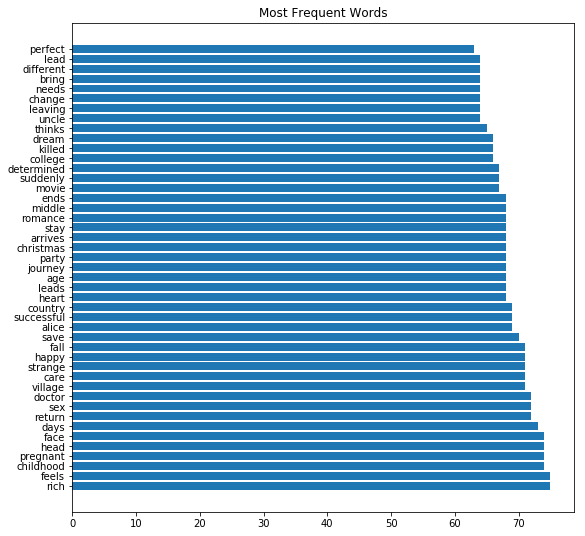

In [102]:
clus1 = movie1.loc[movie1['predictions'] == 0][['title','overview']]
X = vect.fit_transform(clus1['overview'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
text.index = clus1['title']

freq_all = pd.DataFrame(text.sum().sort_values(ascending = False).iloc[145:190], columns=['amount'])

freq_all['words'] = freq_all.index
freq_all.reset_index(inplace = True, drop = True)

plt.figure(figsize=(9,9))
plt.title('Most Frequent Words')
plt.barh(freq_all['words'], freq_all['amount'], align = 'center');

In [86]:
freq_all

,amount,words
0,219,boyfriend
1,214,takes
2,208,story
3,204,decides
4,204,town
5,201,house
6,200,parents
7,200,wants
8,199,job
9,198,death


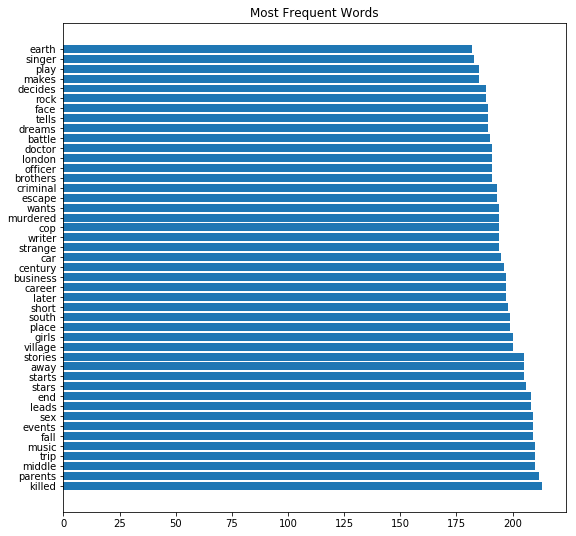

In [104]:
clus2 = movie1.loc[movie1['predictions'] == 1][['title','overview']]
X = vect.fit_transform(clus2['overview'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
text.index = clus2['title']

freq_all = pd.DataFrame(text.sum().sort_values(ascending = False).iloc[145:190], columns=['amount'])

freq_all['words'] = freq_all.index
freq_all.reset_index(inplace = True, drop = True)

plt.figure(figsize=(9,9))
plt.title('Most Frequent Words')
plt.barh(freq_all['words'], freq_all['amount'], align = 'center');

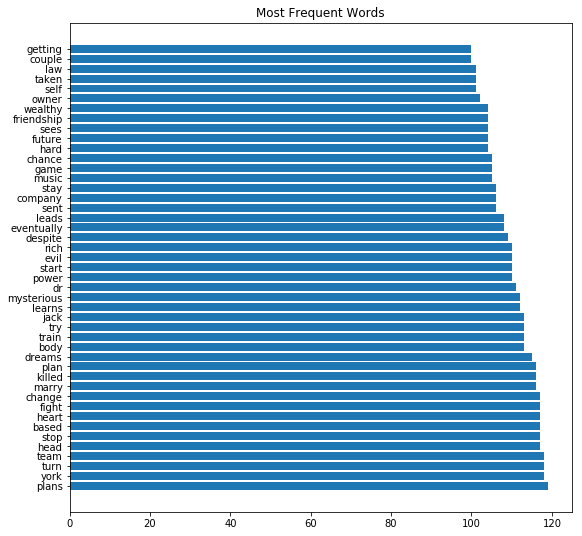

In [105]:
clus3 = movie1.loc[movie1['predictions'] == 2][['title','overview']]
X = vect.fit_transform(clus3['overview'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
text.index = clus3['title']

freq_all = pd.DataFrame(text.sum().sort_values(ascending = False).iloc[145:190], columns=['amount'])

freq_all['words'] = freq_all.index
freq_all.reset_index(inplace = True, drop = True)

plt.figure(figsize=(9,9))
plt.title('Most Frequent Words')
plt.barh(freq_all['words'], freq_all['amount'], align = 'center');

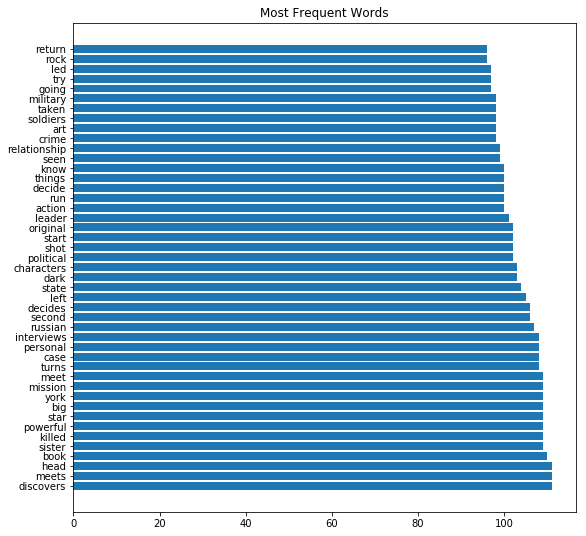

In [106]:
clus4 = movie1.loc[movie1['predictions'] == 3][['title','overview']]
X = vect.fit_transform(clus4['overview'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
text.index = clus4['title']

freq_all = pd.DataFrame(text.sum().sort_values(ascending = False).iloc[145:190], columns=['amount'])

freq_all['words'] = freq_all.index
freq_all.reset_index(inplace = True, drop = True)

plt.figure(figsize=(9,9))
plt.title('Most Frequent Words')
plt.barh(freq_all['words'], freq_all['amount'], align = 'center');

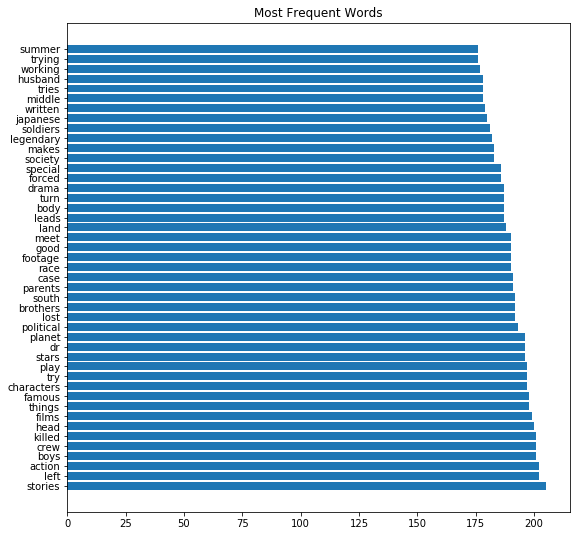

In [107]:
clus5 = movie1.loc[movie1['predictions'] == 4][['title','overview']]
X = vect.fit_transform(clus5['overview'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
text.index = clus5['title']

freq_all = pd.DataFrame(text.sum().sort_values(ascending = False).iloc[145:190], columns=['amount'])

freq_all['words'] = freq_all.index
freq_all.reset_index(inplace = True, drop = True)

plt.figure(figsize=(9,9))
plt.title('Most Frequent Words')
plt.barh(freq_all['words'], freq_all['amount'], align = 'center');

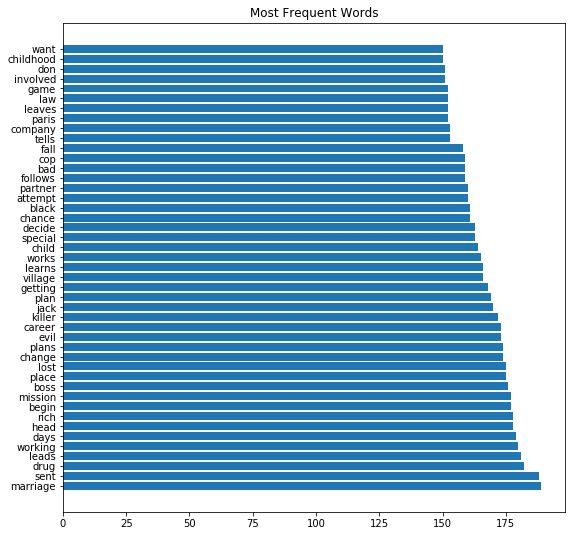

In [108]:
clus6 = movie1.loc[movie1['predictions'] == 5][['title','overview']]
X = vect.fit_transform(clus6['overview'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
text.index = clus6['title']

freq_all = pd.DataFrame(text.sum().sort_values(ascending = False).iloc[145:190], columns=['amount'])

freq_all['words'] = freq_all.index
freq_all.reset_index(inplace = True, drop = True)

plt.figure(figsize=(9,9))
plt.title('Most Frequent Words')
plt.barh(freq_all['words'], freq_all['amount'], align = 'center');

In [44]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(model.cluster_centers_)
centroids.head()

,0,1,2,3,4,5,6,7,8,9,...,76387,76388,76389,76390,76391,76392,76393,76394,76395,76396
0,0.000431,0.003879,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000103,0.004363,0.000051,0.000000,0.000000,0.0,0.000051,0.0,0.000103,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000051,0.000051,0.000000
2,0.000994,0.013921,0.000000,0.000663,0.000331,0.0,0.000331,0.0,0.000000,0.0,...,0.000331,0.000000,0.000000,0.000000,0.0,0.0,0.001657,0.000000,0.000000,0.000000
3,0.000713,0.018888,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000713
4,0.000544,0.010767,0.000000,0.000000,0.000000,0.0,0.000761,0.0,0.000000,0.0,...,0.000000,0.000218,0.000109,0.000109,0.0,0.0,0.000000,0.000000,0.000000,0.000000
